In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# 3.2 - Data Preparation

In [3]:
import urllib.request
url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/refs/heads/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'
filename = 'data/data.csv'
urllib.request.urlretrieve(url, filename)

('data/data.csv', <http.client.HTTPMessage at 0x2808c33d370>)

In [3]:
filename = 'data/data.csv'
df = pd.read_csv(filename)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in categorical_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [5]:
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')

In [6]:
df.totalcharges = df.totalcharges.fillna(0)

In [7]:
df.churn = (df.churn == 'yes').astype(int)

# 3.3 Setting up the validation framework

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [10]:
len(df_full_train), len(df_test)

(5634, 1409)

In [11]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [12]:
len(df_train), len(df_val), len(df_test)

(4225, 1409, 1409)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
y_train = df_train['churn'].values
y_val = df_val['churn'].values
y_test = df_test['churn'].values

In [15]:
del df_train["churn"]
del df_val["churn"]
del df_test["churn"]

# 3.4 EDA

In [16]:
df_full_train = df_full_train.reset_index(drop=True)

In [17]:
df_full_train.churn.value_counts(normalize=True)

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

In [18]:
global_churn_rate = df_full_train.churn.mean()
round(global_churn_rate, 2)

0.27

In [19]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = [col for col in df_full_train.columns if col not in numerical and col not in ['churn', 'customerid']]
categorical

['gender',
 'seniorcitizen',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod']

In [20]:
{col: df_full_train[col].unique() for col in categorical}

{'gender': array(['male', 'female'], dtype=object),
 'seniorcitizen': array([0, 1], dtype=int64),
 'partner': array(['yes', 'no'], dtype=object),
 'dependents': array(['yes', 'no'], dtype=object),
 'phoneservice': array(['yes', 'no'], dtype=object),
 'multiplelines': array(['no', 'yes', 'no_phone_service'], dtype=object),
 'internetservice': array(['no', 'dsl', 'fiber_optic'], dtype=object),
 'onlinesecurity': array(['no_internet_service', 'yes', 'no'], dtype=object),
 'onlinebackup': array(['no_internet_service', 'yes', 'no'], dtype=object),
 'deviceprotection': array(['no_internet_service', 'yes', 'no'], dtype=object),
 'techsupport': array(['no_internet_service', 'yes', 'no'], dtype=object),
 'streamingtv': array(['no_internet_service', 'no', 'yes'], dtype=object),
 'streamingmovies': array(['no_internet_service', 'yes', 'no'], dtype=object),
 'contract': array(['two_year', 'one_year', 'month-to-month'], dtype=object),
 'paperlessbilling': array(['no', 'yes'], dtype=object),
 'payme

In [21]:
df_full_train[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

# 3.5 Feature importance

In [22]:
churn_female = df_full_train[df_full_train['gender'] == 'female'].churn.mean()
churn_female

0.27682403433476394

In [23]:
churn_male = df_full_train[df_full_train['gender'] == 'male'].churn.mean()
churn_male

0.2632135306553911

In [24]:
global_churn_rate - churn_male

0.006754520462819769

In [25]:
global_churn_rate - churn_female

-0.006855983216553063

In [26]:
global_churn_rate

0.26996805111821087

In [27]:
df_full_train.partner.value_counts()

partner
no     2932
yes    2702
Name: count, dtype: int64

In [28]:
churn_partner = df_full_train[df_full_train['partner'] == 'yes'].churn.mean()
churn_partner

0.20503330866025166

In [29]:
churn_partner_no = df_full_train[df_full_train['partner'] == 'no'].churn.mean()
churn_partner_no

0.3298090040927694

In [30]:
global_churn_rate - churn_partner

0.06493474245795922

In [31]:
global_churn_rate - churn_partner_no

-0.05984095297455855

In [32]:
churn_partner/global_churn_rate

0.7594724924338315

In [33]:
churn_partner_no/global_churn_rate

1.2216593879412643

In [35]:
churn_male/global_churn_rate

0.9749802969838747

In [36]:
churn_female/global_churn_rate

1.0253955354648652

```
SELECT
    gender,
    AVG(churn),
    AVG(churn) - global_churn AS diff,
    AVG(churn) / global_churn AS risk
FROM
    data
GROUP BY
    gender;
```

In [34]:
for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).churn.agg(['mean','count'])
    df_group['diff'] = df_group['mean'] - global_churn_rate
    df_group['risk'] = df_group['mean'] / global_churn_rate
    print(df_group)
    print()
    print()

gender
            mean  count      diff      risk
gender                                     
female  0.276824   2796  0.006856  1.025396
male    0.263214   2838 -0.006755  0.974980


seniorcitizen
                   mean  count      diff      risk
seniorcitizen                                     
0              0.242270   4722 -0.027698  0.897403
1              0.413377    912  0.143409  1.531208


partner
             mean  count      diff      risk
partner                                     
no       0.329809   2932  0.059841  1.221659
yes      0.205033   2702 -0.064935  0.759472


dependents
                mean  count      diff      risk
dependents                                     
no          0.313760   3968  0.043792  1.162212
yes         0.165666   1666 -0.104302  0.613651


phoneservice
                  mean  count      diff      risk
phoneservice                                     
no            0.241316    547 -0.028652  0.893870
yes           0.273049   5087  0.0030

# 3.6 Mutual info (importance of categorical vars)

In [35]:
from sklearn.metrics import mutual_info_score, confusion_matrix

In [39]:
mutual_info_score(df_full_train.contract, df_full_train.churn)

0.0983203874041556

In [40]:
mutual_info_score(df_full_train.gender, df_full_train.churn)

0.0001174846211139946

In [41]:
mutual_info_score(df_full_train.partner, df_full_train.churn)

0.009967689095399745

In [36]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)

In [37]:
mi = df_full_train[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

# 3.7 Correlation (importance of numerical vars)

In [38]:
df_full_train[numerical].corrwith(df_full_train.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [39]:
df_full_train[df_full_train.tenure <= 2].churn.mean()

0.5953420669577875

In [46]:
df_full_train[(df_full_train.tenure > 2) & (df_full_train.tenure <= 12)].churn.mean()

0.3994413407821229

In [47]:
df_full_train[df_full_train.tenure > 12].churn.mean()

0.17634908339788277

In [48]:
df_full_train[df_full_train.monthlycharges <= 20].churn.mean()

0.08795411089866156

In [49]:
df_full_train[(df_full_train.monthlycharges > 20) & (df_full_train.monthlycharges <= 50)].churn.mean()

0.18340943683409436

In [50]:
df_full_train[df_full_train.monthlycharges > 50].churn.mean()

0.32499341585462205

In [51]:
df_full_train[numerical].corrwith(df_full_train.churn).abs()

tenure            0.351885
monthlycharges    0.196805
totalcharges      0.196353
dtype: float64

# 3.8 One-hot encoding

In [40]:
from sklearn.feature_extraction import DictVectorizer

In [41]:
df_train[['gender', 'contract']].iloc[:10]

,gender,contract
0,female,two_year
1,male,month-to-month
2,female,month-to-month
3,female,month-to-month
4,female,two_year
5,male,month-to-month
6,male,month-to-month
7,female,month-to-month
8,female,two_year
9,female,month-to-month


In [42]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
train_dicts[:10]

[{'gender': 'female',
  'seniorcitizen': 0,
  'partner': 'yes',
  'dependents': 'yes',
  'phoneservice': 'yes',
  'multiplelines': 'yes',
  'internetservice': 'fiber_optic',
  'onlinesecurity': 'yes',
  'onlinebackup': 'yes',
  'deviceprotection': 'yes',
  'techsupport': 'yes',
  'streamingtv': 'yes',
  'streamingmovies': 'yes',
  'contract': 'two_year',
  'paperlessbilling': 'yes',
  'paymentmethod': 'electronic_check',
  'tenure': 72,
  'monthlycharges': 115.5,
  'totalcharges': 8425.15},
 {'gender': 'male',
  'seniorcitizen': 0,
  'partner': 'no',
  'dependents': 'no',
  'phoneservice': 'yes',
  'multiplelines': 'yes',
  'internetservice': 'fiber_optic',
  'onlinesecurity': 'no',
  'onlinebackup': 'yes',
  'deviceprotection': 'yes',
  'techsupport': 'no',
  'streamingtv': 'no',
  'streamingmovies': 'yes',
  'contract': 'month-to-month',
  'paperlessbilling': 'yes',
  'paymentmethod': 'electronic_check',
  'tenure': 10,
  'monthlycharges': 95.25,
  'totalcharges': 1021.55},
 {'gender

In [43]:
train_dicts[0]

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'yes',
 'deviceprotection': 'yes',
 'techsupport': 'yes',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'two_year',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 72,
 'monthlycharges': 115.5,
 'totalcharges': 8425.15}

In [44]:
dv = DictVectorizer(sparse=False)

In [45]:
X_train = dv.fit_transform(train_dicts)
X_train

array([[0.00000e+00, 0.00000e+00, 1.00000e+00, ..., 1.00000e+00,
        7.20000e+01, 8.42515e+03],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        1.00000e+01, 1.02155e+03],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        5.00000e+00, 4.13650e+02],
       ...,
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        2.00000e+00, 1.90050e+02],
       [0.00000e+00, 0.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        2.70000e+01, 7.61950e+02],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        9.00000e+00, 7.51650e+02]])

In [46]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [47]:
X_train.shape

(4225, 45)

# 3.9 Logistic Regression

In [48]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [49]:
z = np.linspace(-7, 7, 51)
z

array([-7.0000000e+00, -6.7200000e+00, -6.4400000e+00, -6.1600000e+00,
       -5.8800000e+00, -5.6000000e+00, -5.3200000e+00, -5.0400000e+00,
       -4.7600000e+00, -4.4800000e+00, -4.2000000e+00, -3.9200000e+00,
       -3.6400000e+00, -3.3600000e+00, -3.0800000e+00, -2.8000000e+00,
       -2.5200000e+00, -2.2400000e+00, -1.9600000e+00, -1.6800000e+00,
       -1.4000000e+00, -1.1200000e+00, -8.4000000e-01, -5.6000000e-01,
       -2.8000000e-01,  8.8817842e-16,  2.8000000e-01,  5.6000000e-01,
        8.4000000e-01,  1.1200000e+00,  1.4000000e+00,  1.6800000e+00,
        1.9600000e+00,  2.2400000e+00,  2.5200000e+00,  2.8000000e+00,
        3.0800000e+00,  3.3600000e+00,  3.6400000e+00,  3.9200000e+00,
        4.2000000e+00,  4.4800000e+00,  4.7600000e+00,  5.0400000e+00,
        5.3200000e+00,  5.6000000e+00,  5.8800000e+00,  6.1600000e+00,
        6.4400000e+00,  6.7200000e+00,  7.0000000e+00])

In [50]:
sigmoid(z)

array([9.11051194e-04, 1.20508423e-03, 1.59386223e-03, 2.10780106e-03,
       2.78699622e-03, 3.68423990e-03, 4.86893124e-03, 6.43210847e-03,
       8.49286285e-03, 1.12064063e-02, 1.47740317e-02, 1.94550846e-02,
       2.55807883e-02, 3.35692233e-02, 4.39398154e-02, 5.73241759e-02,
       7.44679452e-02, 9.62155417e-02, 1.23467048e-01, 1.57095469e-01,
       1.97816111e-01, 2.46011284e-01, 3.01534784e-01, 3.63547460e-01,
       4.30453776e-01, 5.00000000e-01, 5.69546224e-01, 6.36452540e-01,
       6.98465216e-01, 7.53988716e-01, 8.02183889e-01, 8.42904531e-01,
       8.76532952e-01, 9.03784458e-01, 9.25532055e-01, 9.42675824e-01,
       9.56060185e-01, 9.66430777e-01, 9.74419212e-01, 9.80544915e-01,
       9.85225968e-01, 9.88793594e-01, 9.91507137e-01, 9.93567892e-01,
       9.95131069e-01, 9.96315760e-01, 9.97213004e-01, 9.97892199e-01,
       9.98406138e-01, 9.98794916e-01, 9.99088949e-01])

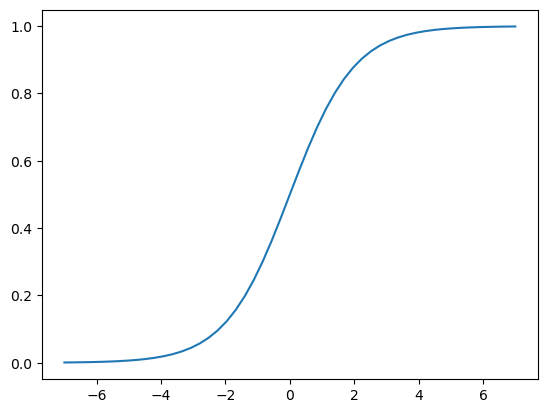

In [51]:
plt.plot(z, sigmoid(z))

In [52]:
def linear_regression(xi):
    result = w0
    
    for j in range(len(w)):
        result += xi[j] * w[j]
    return result

def logistic_regression(xi):
    score = w0
    
    for j in range(len(w)):
        score += xi[j] * w[j]
    
    result = sigmoid(score)
    return result

# 3.10 Training logistic regression with Scikit-learn

In [74]:
from sklearn.linear_model import LogisticRegression

In [75]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [76]:
model.coef_

array([[ 4.74728624e-01, -1.74872862e-01, -4.07535184e-01,
        -2.96786536e-02, -7.80007679e-02,  6.26849567e-02,
        -8.89697132e-02, -8.13946650e-02, -3.43112283e-02,
        -7.33681931e-02, -3.35213502e-01,  3.16503794e-01,
        -8.89697132e-02,  3.67496503e-03, -2.58138174e-01,
         1.41435338e-01,  9.02341416e-03,  6.25315284e-02,
        -8.89697132e-02, -8.12412367e-02,  2.65588833e-01,
        -8.89697132e-02, -2.84298541e-01, -2.31210530e-01,
         1.23531108e-01, -1.66016537e-01,  5.83371158e-02,
        -8.70093394e-02, -3.20596826e-02,  7.04944854e-02,
        -5.91048849e-02,  1.41435338e-01, -2.49114760e-01,
         2.15475176e-01, -1.20364883e-01, -8.89697132e-02,
         1.01655175e-01, -7.08945655e-02, -8.89697132e-02,
         5.21848572e-02,  2.13385956e-01, -8.89697132e-02,
        -2.32095664e-01, -7.04074076e-02,  3.82387541e-04]])

In [77]:
y_pred = model.predict_proba(X_val)[:, 1]

In [78]:
y_pred

array([0.00899651, 0.20452244, 0.21222495, ..., 0.1363896 , 0.79978028,
       0.83741617])

In [79]:
churn_decision = y_pred>= 0.5

In [80]:
df_val[churn_decision].customerid

3       8433-wxgna
8       3440-jpscl
11      2637-fkfsy
12      7228-omtpn
19      6711-fldfb
           ...    
1397    5976-jcjrh
1398    2034-cgrhz
1399    5276-kqwhg
1407    6521-yytyi
1408    3049-solay
Name: customerid, Length: 311, dtype: object

In [81]:
score = (y_val == churn_decision).mean()

In [82]:
score

0.8034066713981547

In [83]:
t = model.predict(X_val)
(y_val == t).mean()

0.8034066713981547

# 3.11 Model interpretation

In [75]:
model.intercept_

array([-0.04738258])

In [76]:
model.coef_[0]

array([ 6.82283264e-01,  3.30015611e-02, -6.77385900e-01,  5.37120149e-02,
       -1.58130885e-02,  1.12236013e-01, -1.58524210e-01,  8.41871236e-02,
        3.81278070e-02, -2.28880424e-04, -4.94448737e-01,  6.90871875e-01,
       -1.58524210e-01, -1.75575534e-02, -1.89126456e-01,  6.83786900e-02,
        1.58646692e-01,  1.15496068e-01, -1.58524210e-01,  8.09270684e-02,
        2.84471150e-01, -1.58524210e-01, -8.80480129e-02, -1.62612888e-01,
        2.00511814e-01, -4.45698930e-02,  8.24688193e-02, -5.32151150e-02,
       -3.22274515e-03,  1.06571014e-01, -1.22342276e-02,  6.83786900e-02,
       -3.04797635e-02,  1.93048231e-01, -9.44938826e-02, -1.58524210e-01,
        2.90917019e-01, -5.44261578e-02, -1.58524210e-01,  2.50849294e-01,
        2.34163257e-01, -1.58524210e-01, -3.77401203e-02, -6.85254972e-02,
        3.95898761e-04])

In [77]:
dict(zip(dv.get_feature_names_out(),model.coef_[0].round(3)))

{'contract=month-to-month': 0.682,
 'contract=one_year': 0.033,
 'contract=two_year': -0.677,
 'dependents=no': 0.054,
 'dependents=yes': -0.016,
 'deviceprotection=no': 0.112,
 'deviceprotection=no_internet_service': -0.159,
 'deviceprotection=yes': 0.084,
 'gender=female': 0.038,
 'gender=male': -0.0,
 'internetservice=dsl': -0.494,
 'internetservice=fiber_optic': 0.691,
 'internetservice=no': -0.159,
 'monthlycharges': -0.018,
 'multiplelines=no': -0.189,
 'multiplelines=no_phone_service': 0.068,
 'multiplelines=yes': 0.159,
 'onlinebackup=no': 0.115,
 'onlinebackup=no_internet_service': -0.159,
 'onlinebackup=yes': 0.081,
 'onlinesecurity=no': 0.284,
 'onlinesecurity=no_internet_service': -0.159,
 'onlinesecurity=yes': -0.088,
 'paperlessbilling=no': -0.163,
 'paperlessbilling=yes': 0.201,
 'partner=no': -0.045,
 'partner=yes': 0.082,
 'paymentmethod=bank_transfer_(automatic)': -0.053,
 'paymentmethod=credit_card_(automatic)': -0.003,
 'paymentmethod=electronic_check': 0.107,
 'pay

# 3.12 Using the model

In [62]:
dicts_full_train = df_full_train[categorical + numerical].to_dict(orient='records')

In [63]:
dicts_full_train[:10]

[{'gender': 'male',
  'seniorcitizen': 0,
  'partner': 'yes',
  'dependents': 'yes',
  'phoneservice': 'yes',
  'multiplelines': 'no',
  'internetservice': 'no',
  'onlinesecurity': 'no_internet_service',
  'onlinebackup': 'no_internet_service',
  'deviceprotection': 'no_internet_service',
  'techsupport': 'no_internet_service',
  'streamingtv': 'no_internet_service',
  'streamingmovies': 'no_internet_service',
  'contract': 'two_year',
  'paperlessbilling': 'no',
  'paymentmethod': 'mailed_check',
  'tenure': 12,
  'monthlycharges': 19.7,
  'totalcharges': 258.35},
 {'gender': 'female',
  'seniorcitizen': 0,
  'partner': 'no',
  'dependents': 'no',
  'phoneservice': 'yes',
  'multiplelines': 'no',
  'internetservice': 'dsl',
  'onlinesecurity': 'yes',
  'onlinebackup': 'yes',
  'deviceprotection': 'yes',
  'techsupport': 'yes',
  'streamingtv': 'no',
  'streamingmovies': 'yes',
  'contract': 'one_year',
  'paperlessbilling': 'no',
  'paymentmethod': 'credit_card_(automatic)',
  'tenur

In [64]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

In [65]:
y_full_train = df_full_train['churn'].values

In [66]:
model = LogisticRegression(max_iter=2700)
model.fit(X_full_train, y_full_train)

LogisticRegression(max_iter=2700)

In [67]:
dicts_test = df_test[categorical + numerical].to_dict(orient='records')

In [68]:
X_test = dv.transform(dicts_test)

In [69]:
y_pred = model.predict_proba(X_test)[:, 1]

In [70]:
churn_decision = y_pred>= 0.5

In [71]:
(churn_decision == y_test).mean()

0.815471965933286

# 4.2 Accuracy and dummy model

In [84]:
len(y_val)

1409

In [85]:
(y_val == churn_decision).sum()

1132

In [86]:
1132/1409

0.8034066713981547

In [87]:
thresholds = np.linspace(0, 1, 21)
scores = []
print(thresholds)
for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


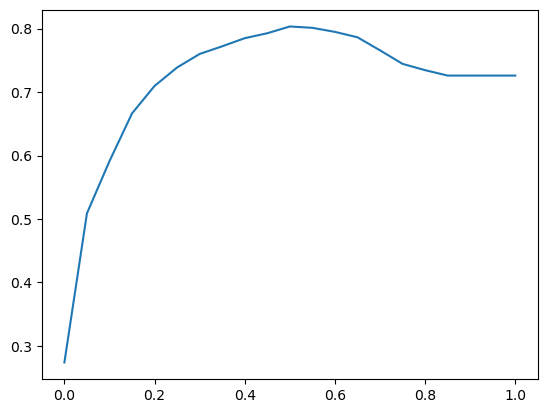

In [88]:
plt.plot(thresholds, scores)

In [89]:
from sklearn.metrics import accuracy_score

In [90]:
thresholds = np.linspace(0, 1, 21)
scores = []
for t in thresholds:
    churn_decision = (y_pred >= t)
    score = accuracy_score(y_val, churn_decision)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [91]:
y_val.mean()

0.2739531582682754

In [92]:
1 - y_val.mean()

0.7260468417317246

# 4.3 Confusion table

![conf-oval](images/conf-oval.png)

![conf-mat](images/conf-mat.png)

In [93]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [94]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [95]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [96]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [97]:
tp, tn, fp, fn

(210, 922, 101, 176)

In [98]:
confusion_matrix = np.array([[tn,fp],[fn,tp]])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [99]:
(confusion_matrix/confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

# 4.4 precision and recall


In [100]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy

0.8034066713981547

In [101]:
precision = tp / (tp + fp)
precision

0.6752411575562701

In [102]:
recall = tp / (tp + fn)
recall

0.5440414507772021

![prec-recall](images/precision-recall.png)

# 4.5 ROC (Receiver operating characteristics)

![fpr-tpr](images/FPR-TPR.png)

In [103]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [104]:
recall

0.5440414507772021

In [105]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [106]:
thresholds = np.linspace(0, 1, 101)
scores = []
for t in thresholds:    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    # print('%.2f %.3f' % (t, score))
    scores.append((t,tp,fp,fn,tn))

In [107]:
cols = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns = cols)

In [108]:
df_scores['tpr'] = df_scores.tp/(df_scores.tp+df_scores.fn)
df_scores['fpr'] = df_scores.fp/(df_scores.tn+df_scores.fp)

In [109]:
df_scores

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,385,913,1,110,0.997409,0.892473
2,0.02,384,830,2,193,0.994819,0.811339
3,0.03,383,766,3,257,0.992228,0.748778
4,0.04,381,715,5,308,0.987047,0.698925
...,...,...,...,...,...,...,...
96,0.96,0,0,386,1023,0.000000,0.000000
97,0.97,0,0,386,1023,0.000000,0.000000
98,0.98,0,0,386,1023,0.000000,0.000000
99,0.99,0,0,386,1023,0.000000,0.000000


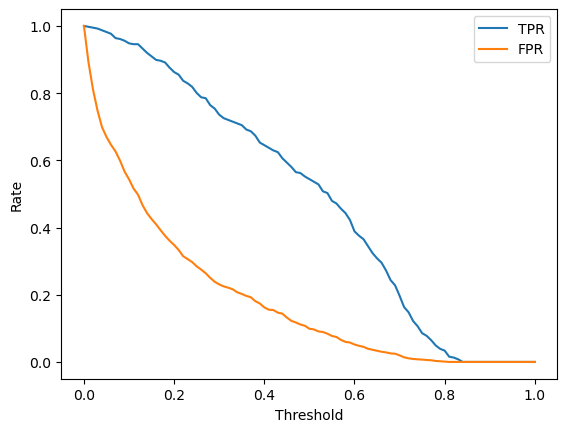

In [110]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.show()

In [111]:
def tpr_fpr_df(y_val, y_pred):
    thresholds = np.linspace(0, 1, 101)

    actual_negative = (y_val == 0)
    actual_positive = (y_val == 1)
    scores = []
    for t in thresholds:
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
        
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        scores.append((t, tp, fp, fn, tn))
        
    cols = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=cols)
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.tn + df_scores.fp)
    
    return df_scores

## Random model

In [112]:
np.random.seed(1)
y_rand = np.random.uniform(0,1,size=len(y_val))
((y_rand > 0.5) == y_val).mean()

0.5017743080198722

In [113]:
df_rand = tpr_fpr_df(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


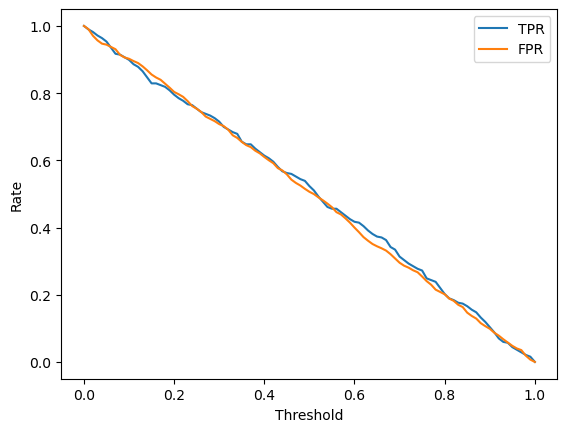

In [114]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.show()

## Ideal model

In [115]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [116]:
y_ideal = np.repeat([0,1],[num_neg,num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [118]:
y_ideal_pred = np.linspace(0,1,len(y_val))

In [120]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [123]:
y_ideal_pred.round(3)

array([0.   , 0.001, 0.001, ..., 0.999, 0.999, 1.   ])

In [124]:
df_ideal = tpr_fpr_df(y_ideal, y_ideal_pred)

In [125]:
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


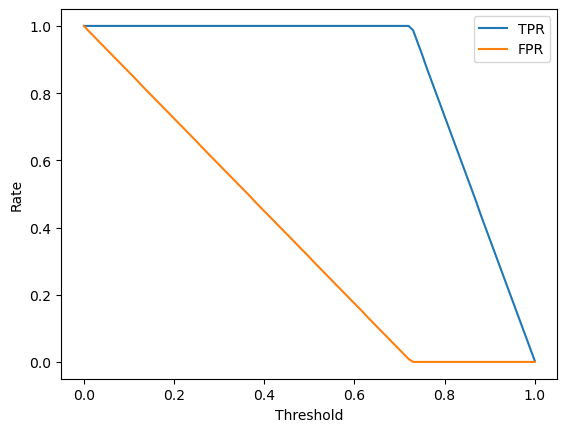

In [126]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.show()

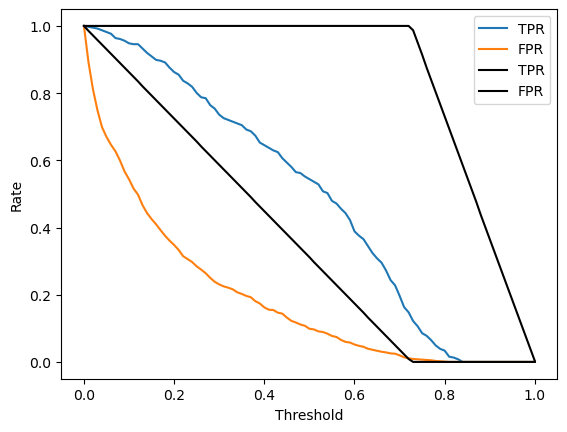

In [131]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')

# plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
# plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')

plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR', color='black')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR', color='black')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.show()

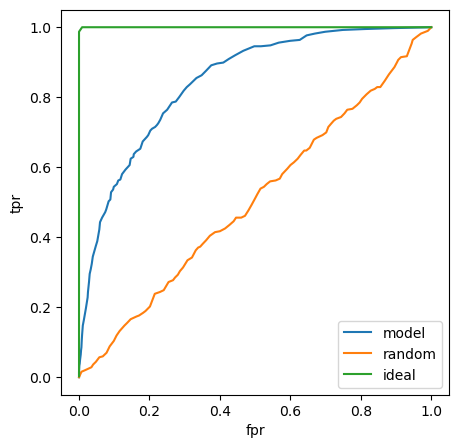

In [136]:
plt.figure(figsize=(5,5))
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()

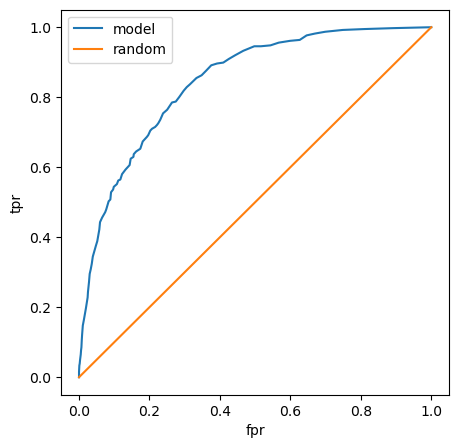

In [135]:
plt.figure(figsize=(5,5))
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0,1], [0,1], label='random')

plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()

In [137]:
from sklearn.metrics import roc_curve

In [138]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

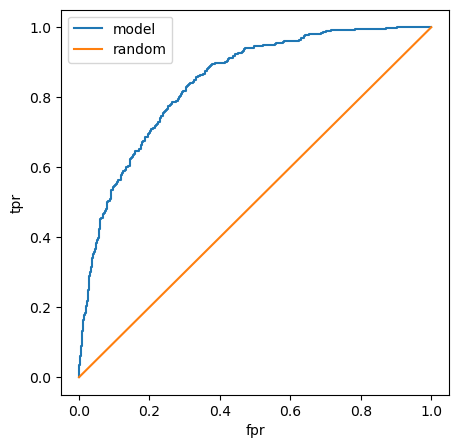

In [139]:
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='model')
plt.plot([0,1], [0,1], label='random')

plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()

# 4.6 ROC AUC

In [140]:
from sklearn.metrics import auc

In [141]:
auc(fpr, tpr)

0.8438581030090306

In [142]:
auc(df_scores.fpr, df_scores.tpr)

0.8438606354367678

In [143]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [144]:
auc(df_rand.fpr, df_rand.tpr)

0.5060233793728696

In [145]:
fpr,tpr,thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438581030090306

In [146]:
from sklearn.metrics import roc_auc_score

In [147]:
roc_auc_score(y_val, y_pred)

0.8438581030090306

In [149]:
#AUC represents prob of randomly selected +ve example has higher score than randomly selected -ve example

In [150]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [151]:
import random

In [158]:
n = 100000
success = 0
for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)
    
    success += pos[pos_ind] > neg[neg_ind]
success/n

0.84395

In [163]:
n= 50000
np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)
(pos[pos_ind] > neg[neg_ind]).mean()

0.84648

# 4.7 Cross validation

In [164]:
def train(df_train,y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return dv, model

In [181]:
def train_reg(df_train,y_train, c = 1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C = c, max_iter=3000)
    model.fit(X_train, y_train)
    return dv, model

In [165]:
dv, model = train(df_train,y_train)

In [166]:
def predict(df,dv,model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred

In [168]:
y_pred = predict(df_val, dv, model)

In [169]:
from sklearn.model_selection import KFold

In [172]:
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
train_idx, val_idx = next(kfold.split(df_full_train))

In [173]:
len(train_idx), len(val_idx)

(5070, 564)

In [174]:
len(df_full_train)

5634

In [175]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [176]:
scores = []
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.churn.values
    y_val = df_val.churn.values
    
    dv, model = train(df_train,y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

C:\Users\Vikram\anaconda3\envs\homl3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vikram\anaconda3\envs\homl3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

In [180]:
print('%.3f  %.3f' % (np.mean(scores), np.std(scores)))

0.841  0.013


In [182]:
from tqdm.auto import tqdm

In [187]:
n_splits = 5
for c in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    scores = []
    kfold = KFold(n_splits=n_splits, random_state=1, shuffle=True)
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.churn.values
        y_val = df_val.churn.values
        
        dv, model = train_reg(df_train,y_train, c=c)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('%s %.3f  %.3f' % (c, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

0.001 0.825  0.009
0.01 0.840  0.009
0.1 0.840  0.008
0.5 0.841  0.007
1 0.840  0.009
5 0.841  0.008
10 0.841  0.008


In [188]:
dv, model = train_reg(df_full_train,df_full_train.churn.values, c=1)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259